<strong><em>Student Academic Performance Prediction:</em></strong><br>
***
This notebook attempts to study some of the factors affecting student academic success, the first measurement of success being the GPA and the second being eligibility for application of a master's degree

Features being studied are:<br>
<ul> 
<li>SAT score</li>
<li>Athletism</li>
<li>High School Size</li>
<li>High School Rank</li>
<li>High School Percentile</li>
<li>Gender</li>
</ul>
<hr>

<br>

<h3>Libraries Import</h3>
<hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Ridge , LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import statsmodels.api as sm
from dash import dash, dcc, html, Input, Output
import plotly.express as px


<h3> Data Import</h3>
<p>The main dataframes are:</p> 
<ol>
<li>merged_df</li>
<li>unchanged_df</li>
</ol>
<p>Where <strong>merged_df</strong> is the dataframe we're going to experiment on </p>
<p>And <strong>unchaged_df</strong> is the dataframe used for the plots</p>
<hr>

In [2]:
merged_df= pd.read_csv('GPA2.csv')
unchanged_df = pd.read_csv('GPA2.csv') # For the "before" graphs


In [3]:
#adding a "success" column
success =[]
successCount = 0;
failCount = 0;
for i in merged_df["gpa"]:
    if(i >= (3)):
        success.append(True)
        successCount+= 1
    else:
        success.append(False)
        failCount+=1

merged_df.insert(7,"Success", success);
print("Succes Count is: ", successCount)
print("Fail Count is: ", failCount)

Succes Count is:  1300
Fail Count is:  2835


  <h3>Exploratory Data Analysis <strong>EDA</strong></h3>
    <p>This part includes:</p>
    <ul>
        <li>Overview of the data</li>
        <li>Graphs for the data</li>
        <li>A dashboard</li>
    </ul>
    <p>Ambiguous or unclear graphs will be explained in the comments.</p>

In [4]:
unchanged_df

,gpa,SAT,athlete,hsize,hsrank,hsperc,female
0,2.04,920,1,10,4,40.000000,1
1,4.00,1170,0,940,191,20.319150,0
2,1.78,810,1,119,42,35.294120,0
3,2.42,940,0,571,252,44.133100,0
4,2.61,1180,0,214,86,40.186920,0
...,...,...,...,...,...,...,...
4130,2.24,990,0,233,89,38.197430,1
4131,2.46,900,0,10,2,20.000000,1
4132,4.00,1340,0,45,1,2.222222,0
4133,2.83,980,0,35,23,65.714290,1


In [5]:
unchanged_df.describe()

,gpa,SAT,athlete,hsize,hsrank,hsperc,female
count,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000
mean,2.653969,1030.324063,0.046917,279.882709,52.777993,19.229207,0.449819
std,0.656204,139.422201,0.211486,173.576713,64.636182,16.568810,0.497536
min,0.210000,470.000000,0.000000,3.000000,1.000000,0.166667,0.000000
25%,2.210000,940.000000,0.000000,164.500000,11.000000,6.430659,0.000000
50%,2.660000,1030.000000,0.000000,251.000000,30.000000,14.583330,0.000000
75%,3.120000,1120.000000,0.000000,368.000000,70.000000,27.681105,1.000000
max,4.000000,1540.000000,1.000000,940.000000,634.000000,92.000000,1.000000


In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4135 entries, 0 to 4134
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gpa      4135 non-null   float64
 1   SAT      4135 non-null   int64  
 2   athlete  4135 non-null   int64  
 3   hsize    4135 non-null   int64  
 4   hsrank   4135 non-null   int64  
 5   hsperc   4135 non-null   float64
 6   female   4135 non-null   int64  
 7   Success  4135 non-null   bool   
dtypes: bool(1), float64(2), int64(5)
memory usage: 230.3 KB


In [7]:
# we first check for duplicates:
print("Duplicates in data frame:\n",unchanged_df[unchanged_df.duplicated()])
# we found a duplicate in the df, it's student number 533

Duplicates in data frame:
       gpa   SAT  athlete  hsize  hsrank  hsperc  female
533  3.17  1060        0     10       2    20.0       1


In [8]:
merged_df= merged_df.drop_duplicates()
#here we saved the merged_df without the duplicate
merged_df.info()
#we can notice that the data is now one entry less. (it was 4135 and now is 4134)

<class 'pandas.core.frame.DataFrame'>
Index: 4134 entries, 0 to 4134
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gpa      4134 non-null   float64
 1   SAT      4134 non-null   int64  
 2   athlete  4134 non-null   int64  
 3   hsize    4134 non-null   int64  
 4   hsrank   4134 non-null   int64  
 5   hsperc   4134 non-null   float64
 6   female   4134 non-null   int64  
 7   Success  4134 non-null   bool   
dtypes: bool(1), float64(2), int64(5)
memory usage: 262.4 KB


In [9]:
# do this again after the duplicate is gone
merged_df.describe()
#we can also conclude a few things from this. for example, nearly half of these students are female, 
#and almost 5% only are athletes

,gpa,SAT,athlete,hsize,hsrank,hsperc,female
count,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000
mean,2.653844,1030.316884,0.046928,279.947992,52.790276,19.229020,0.449686
std,0.656234,139.438302,0.211510,173.546932,64.639175,16.570810,0.497522
min,0.210000,470.000000,0.000000,3.000000,1.000000,0.166667,0.000000
25%,2.210000,940.000000,0.000000,165.000000,11.000000,6.429615,0.000000
50%,2.660000,1030.000000,0.000000,251.000000,30.000000,14.579800,0.000000
75%,3.120000,1120.000000,0.000000,368.000000,70.000000,27.686707,1.000000
max,4.000000,1540.000000,1.000000,940.000000,634.000000,92.000000,1.000000


In [13]:
import plotly.graph_objects as go
app = dash.Dash(__name__)

# Define layout
app.layout = html.Div([
    html.H1("Data Visualization Dashboard"),
    dcc.Store(id='plot-type-store', data='scatter'),  # Initialize plot type store with default value
    html.Div([
        dcc.Dropdown(
            id='x-variable',
            options=[{'label': col, 'value': col} for col in unchanged_df.columns[1:] if col not in ['athlete', 'female']],
            value=unchanged_df.columns[1],  # Default value
            clearable=False,
        ),
        dcc.RadioItems(
            id='plot-type',
            options=[
                {'label': 'Scatter Plot', 'value': 'scatter'},
                {'label': 'Bar Plot', 'value': 'bar'},
                {'label': 'Line Plot', 'value': 'line'},
                {'label': 'Histogram', 'value': 'histogram'},
                {'label': 'Box Plot', 'value': 'box'},
                {'label': 'Correlation Matrix', 'value': 'correlation'}
            ],
            value='scatter',  # Default value
            labelStyle={'display': 'block'}
        ),
        dcc.Dropdown(
            id='box-variable',
            options=[
                {'label': 'Female', 'value': 'female'},
                {'label': 'Athlete', 'value': 'athlete'}
            ],
            value='female',
            clearable=False,
            style={'display': 'none'}  # Initially hidden
        )
    ], id='controls', style={'width': '50%', 'margin': 'auto', 'textAlign': 'center'}),
    dcc.Graph(id='graph')
])

@app.callback(
    Output('plot-type-store', 'data'),
    Input('plot-type', 'value')
)
def update_plot_type_store(plot_type):
    return plot_type

@app.callback(
    Output('graph', 'figure'),
    [Input('x-variable', 'value'),
     Input('plot-type-store', 'data'),
     Input('box-variable', 'value')]
)
def update_graph(x_variable, plot_type, box_variable):
    if plot_type == 'scatter':
        fig = px.scatter(unchanged_df, x=x_variable, y='gpa', title=f'GPA vs {x_variable}', labels={'gpa':'GPA Score'})
    elif plot_type == 'bar':
        fig = px.bar(unchanged_df, x=x_variable, y='gpa', title=f'GPA vs {x_variable}', labels={'gpa':'GPA Score'})
    elif plot_type == 'line':
        fig = px.line(unchanged_df, x=x_variable, y='gpa', title=f'GPA vs {x_variable}', labels={'gpa':'GPA Score'})
    elif plot_type == 'histogram':
        bin_num = int(2 * np.cbrt(unchanged_df.size))  # Convert bin_num to an integer
        fig = px.histogram(unchanged_df, x='gpa', title='Histogram of GPA', labels={'gpa': 'GPA Score'}, nbins=bin_num)
    elif plot_type == 'box':
        fig = px.box(unchanged_df, x=box_variable, y='gpa', title=f'GPA vs {box_variable.capitalize()}', labels={'gpa':'GPA Score'})
    elif plot_type == 'correlation':
        correlation_matrix = unchanged_df[['gpa', 'SAT', 'athlete', 'hsize', 'hsrank', 'hsperc', 'female']].corr()
        fig = go.Figure(data=go.Heatmap(
            z=correlation_matrix.values,
            x=correlation_matrix.columns,
            y=correlation_matrix.columns,
            colorscale='RdBu_r',
            zmin=-1, zmax=1
        ))
        fig.update_layout(title='Correlation Matrix', xaxis_nticks=36)
    return fig

@app.callback(
    [Output('x-variable', 'style'),
     Output('box-variable', 'style')],
    Input('plot-type-store', 'data')
)
def show_hide_x_variable(plot_type):
    if plot_type in ['histogram', 'box', 'correlation']:
        return {'display': 'none'}, {'display': 'block'} if plot_type == 'box' else {'display': 'none'}
    else:
        return {'display': 'block'}, {'display': 'none'}

if __name__ == '__main__':
    app.run_server(debug=True, port=8000)
    #if you face an error about the sever being used, change to port=8000


In [12]:
import plotly.graph_objects as go
from dash import State
app = dash.Dash(__name__)

# Define layout
app.layout = html.Div([
    html.H1("Data Visualization Dashboard", style={'textAlign': 'center'}),
    dcc.Store(id='plot-type-store', data='scatter'),  # Store for plot type
    html.Div([
        html.Label("Select Plot Type"),
        dcc.RadioItems(
            id='plot-type',
            options=[
                {'label': 'Scatter Plot', 'value': 'scatter'},
                {'label': 'Bar Plot', 'value': 'bar'},
                {'label': 'Histogram', 'value': 'histogram'},
                {'label': 'Box Plot', 'value': 'box'},
                {'label': 'Correlation Matrix', 'value': 'correlation'}
            ],
            value='scatter',  # Default value
            labelStyle={'display': 'inline-block', 'margin-right': '10px'}
        ),
    ], style={'textAlign': 'center', 'margin-bottom': '20px'}),

    html.Div([
        html.Div([
            html.Label("Select X Variable"),
            dcc.Dropdown(
                id='x-variable',
                options=[{'label': col, 'value': col} for col in unchanged_df.columns[1:] if col not in ['athlete', 'female']],
                value=unchanged_df.columns[1],  # Default value
                clearable=False,
            ),
        ], style={'display': 'block', 'width': '45%', 'margin': 'auto'}),
        
        html.Div([
            html.Label("Select Box Plot Variable"),
            dcc.Dropdown(
                id='box-variable',
                options=[
                    {'label': 'Female', 'value': 'female'},
                    {'label': 'Athlete', 'value': 'athlete'}
                ],
                value='female',
                clearable=False,
                style={'display': 'none'}  # Initially hidden
            ),
        ], style={'display': 'none', 'width': '45%', 'margin': 'auto'}),
    ], style={'textAlign': 'center', 'margin-bottom': '20px'}),

    dcc.Graph(id='graph')
], style={'font-family': 'Arial, sans-serif', 'margin': '20px'})

# Callback to update plot type store
@app.callback(
    Output('plot-type-store', 'data'),
    Input('plot-type', 'value')
)
def update_plot_type_store(plot_type):
    return plot_type

# Callback to show/hide x-variable and box-variable dropdowns
@app.callback(
    [Output('x-variable', 'style'),
     Output('box-variable', 'style')],
    Input('plot-type-store', 'data')
)
def show_hide_x_and_box_variables(plot_type):
    x_style = {'display': 'block'}
    box_style = {'display': 'none'}
    
    if plot_type == 'box':
        box_style = {'display': 'block'}
    elif plot_type in ['histogram', 'correlation']:
        x_style = {'display': 'none'}
    
    return x_style, box_style

# Callback to update graph based on user inputs
@app.callback(
    Output('graph', 'figure'),
    [Input('x-variable', 'value'),
     Input('plot-type', 'value'),
     Input('box-variable', 'value')]
)
def update_graph(x_variable, plot_type, box_variable):
    if plot_type == 'scatter':
        fig = px.scatter(unchanged_df, x=x_variable, y='gpa', title=f'GPA vs {x_variable}', labels={'gpa':'GPA Score'})
    elif plot_type == 'bar':
        fig = px.bar(unchanged_df, x=x_variable, y='gpa', title=f'GPA vs {x_variable}', labels={'gpa':'GPA Score'})
    elif plot_type == 'histogram':
        bin_num = int(2 * np.cbrt(unchanged_df.size))  # Convert bin_num to an integer
        fig = px.histogram(unchanged_df, x='gpa', title='Histogram of GPA', labels={'gpa': 'GPA Score'}, nbins=bin_num)
    elif plot_type == 'box':
        fig = px.box(unchanged_df, x=box_variable, y='gpa', title=f'GPA vs {box_variable.capitalize()}', labels={'gpa':'GPA Score'})
    elif plot_type == 'correlation':
        correlation_matrix = unchanged_df[['gpa', 'SAT', 'athlete', 'hsize', 'hsrank', 'hsperc', 'female']].corr()
        correlation_matrix_text = correlation_matrix.round(2).astype(str)
        fig = go.Figure(data=go.Heatmap(x=correlation_matrix.columns, z=correlation_matrix.values, y=correlation_matrix.columns,
            colorscale='RdBu_r', zmin=-1, zmax=1,text=correlation_matrix_text.values,hoverinfo='text'))
        fig.update_traces(text=correlation_matrix_text.values, texttemplate="%{text}")
        fig.update_layout(title='Correlation Matrix', xaxis_nticks=36)
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8006)
    #if you face an error about the sever being used, change to port=8000

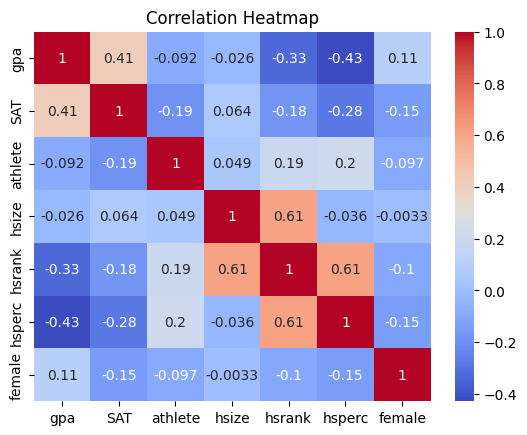

In [ ]:
#this code is probably going to bye bye
# Generate the correlation matrix
correlation_matrix = merged_df[['gpa', 'SAT', 'athlete','hsize','hsrank','hsperc','female']].corr()

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


***
<strong><em>Initial Test Using All of The Dataset:</em></strong><br>
***

In [ ]:
# Split data, we decided to drop hsperc as it is equal to rank/size --> dependent variable
X = merged_df[['SAT', 'athlete','hsize','hsrank','female']]
y = merged_df['gpa']

In [ ]:
#Normal LinearRegression with k = 3 fold cross validation

best_mse = 17 #arbitrarly large MSE, (MSE for 0% accuracy is at maximum 16)
best_model = 0


kf = KFold(n_splits=3, random_state=None)
total_test_mse = 0
total_train_mse = 0
    
for j, (train_index, test_index) in enumerate(kf.split(X)):

    # Train Test split
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # Normalization
    mean_X_train = np.mean(X_train, axis=0)
    std_X_train = np.std(X_train, axis=0)
    mean_y_train = np.mean(y_train)
    std_y_train = np.std(y_train)


    X_train_norm = (X_train - mean_X_train)/std_X_train
    X_test_norm = (X_test - mean_X_train)/std_X_train

    y_train_norm = (y_train - mean_y_train)/std_y_train
    y_test_norm = (y_test - mean_y_train)/std_y_train

    # Linear Regression
    model = LinearRegression(fit_intercept= True)
    model.fit(X_train_norm, y_train_norm)

    # Train and test MSE
    y_train_predict_unnormalized = (model.predict(X_train_norm) * std_y_train) + mean_y_train
    y_test_predict_unnormalized = (model.predict(X_test_norm) * std_y_train) + mean_y_train

    train_mse = np.mean((y_train_predict_unnormalized - y_train) ** 2)
    test_mse = np.mean((y_test_predict_unnormalized - y_test) ** 2)
    total_train_mse += train_mse
    total_test_mse += test_mse

    if (test_mse < best_mse): #Choose the model with lowest MSE for hypothesis testing and R2 Calculation
        best_mse = test_mse
        best_model = model

print("Average Train MSE:", total_train_mse / kf.get_n_splits())
print("Average Test MSE:", total_test_mse / kf.get_n_splits())
print("Best model coeffecients: ", best_model.coef_)


Average Train MSE: 0.31040840158584354
Average Test MSE: 0.31604725075161383
Best model coeffecients:  [ 0.36375544  0.04964304  0.12845051 -0.34996969  0.14916353]


In [ ]:
#ٌR2 Score Calculation

X_all_norm = (X - mean_X_train)/std_X_train
y_pred_all = best_model.predict(X_all_norm)
y_pred_all_unnormalized = (y_pred_all * std_y_train) + mean_y_train

print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))

The r2 score is:  0.2751084818805395


In [ ]:
#Hypothesis testing on the least error model

X_const_added = sm.add_constant(X_all_norm)
est = sm.OLS(y,X_all_norm)
est2 = est.fit()
print(est2.summary())


                                 OLS Regression Results                                
Dep. Variable:                    gpa   R-squared (uncentered):                   0.018
Model:                            OLS   Adj. R-squared (uncentered):              0.017
Method:                 Least Squares   F-statistic:                              15.50
Date:                Fri, 17 May 2024   Prob (F-statistic):                    3.92e-15
Time:                        21:23:12   Log-Likelihood:                         -9984.9
No. Observations:                4134   AIC:                                  1.998e+04
Df Residuals:                    4129   BIC:                                  2.001e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

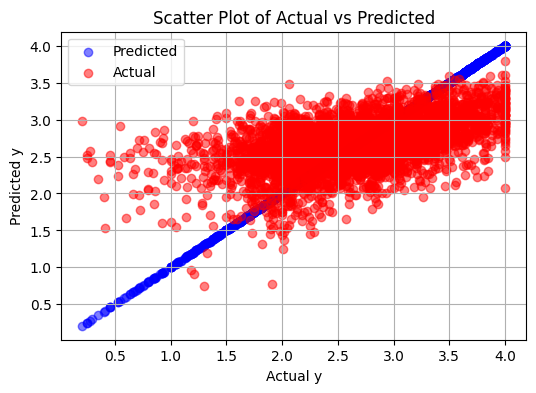

In [ ]:
#Plotting a sample of 500 students


numss = [np.random.randint(1,len(y)) for _ in range(500)]
y_rand = y.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y, y, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y, y_pred_all_unnormalized, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
best_mse = 10
best_model = 0

alphas = [0, 0.1,0.5, 1,10,100]

for i, alpha in enumerate(alphas):

    kf = KFold(n_splits=3, random_state=None)
    total_test_mse = 0
    total_train_mse = 0
        
    for j, (train_index, test_index) in enumerate(kf.split(X)):

        # Train Test split
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        # Normalization
        mean_X_train = np.mean(X_train, axis=0)
        std_X_train = np.std(X_train, axis=0)
        mean_y_train = np.mean(y_train)
        std_y_train = np.std(y_train)


        X_train_norm = (X_train - mean_X_train)/std_X_train
        X_test_norm = (X_test - mean_X_train)/std_X_train

        y_train_norm = (y_train - mean_y_train)/std_y_train
        y_test_norm = (y_test - mean_y_train)/std_y_train

        # Ridge Regression
        model = Ridge(alpha = alpha)
        model.fit(X_train_norm, y_train_norm)

        # Train and test MSE
        y_train_predict_unnormalized = (model.predict(X_train_norm) * std_y_train) + mean_y_train
        y_test_predict_unnormalized = (model.predict(X_test_norm) * std_y_train) + mean_y_train

        train_mse = np.mean((y_train_predict_unnormalized - y_train) ** 2)
        test_mse = np.mean((y_test_predict_unnormalized - y_test) ** 2)
        total_train_mse += train_mse
        total_test_mse += test_mse

        if (test_mse < best_mse):
            best_mse = test_mse
            best_model = model

    print("Average Train MSE:", total_train_mse / kf.get_n_splits())
    print("Average Test MSE:", total_test_mse / kf.get_n_splits())
    print()


Average Train MSE: 0.31040840158584354
Average Test MSE: 0.31604725075161383

Average Train MSE: 0.31040840185693025
Average Test MSE: 0.31604713717081717

Average Train MSE: 0.3104084083591218
Average Test MSE: 0.31604668865331675

Average Train MSE: 0.310408428659533
Average Test MSE: 0.31604614105053325

Average Train MSE: 0.3104110744250321
Average Test MSE: 0.3160387278578406

Average Train MSE: 0.31064514002420934
Average Test MSE: 0.3161871123802222



In [ ]:
X_all_norm = (X - mean_X_train)/std_X_train
y_pred_all = best_model.predict(X_all_norm)
y_pred_all_unnormalized = (y_pred_all * std_y_train) + mean_y_train

print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))

The r2 score is:  0.2751084818805396


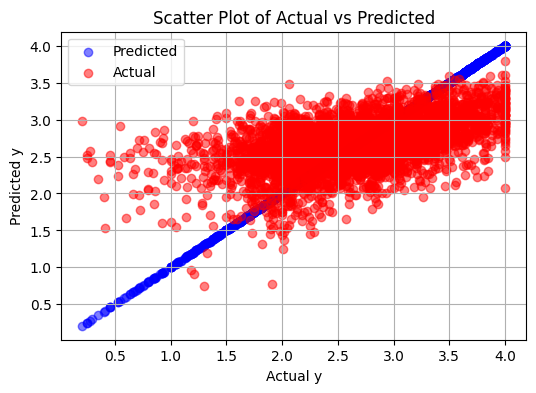

In [ ]:
import matplotlib.pyplot as plt

numss = [np.random.randint(1,len(y)) for _ in range(500)]
y_rand = y.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y, y, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y, y_pred_all_unnormalized, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
best_model = 0
best_mse = 10

# Normalization
mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)


X_train_norm = (X_train - mean_X_train)/std_X_train
X_test_norm = (X_test - mean_X_train)/std_X_train


y_train_norm = (y_train - mean_y_train)/std_y_train
y_test_norm = (y_test - mean_y_train)/std_y_train

degrees = [1,2,4,8]
alphas = [0.1,0.5,1,5,10]
for deg in degrees:

    # Polynomial Features
    poly = PolynomialFeatures(degree=deg, include_bias= True)  # You can adjust the degree as needed
    X_poly_train_norm = poly.fit_transform(X_train_norm)

    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train_norm, y_train_norm)

        X_poly_test_norm = poly.fit_transform(X_test_norm)


        train_mse = mean_squared_error(y_train, (model.predict(X_poly_train_norm)*std_y_train)+mean_y_train)
        test_mse = mean_squared_error(y_test, (model.predict(X_poly_test_norm)*std_y_train)+mean_y_train)
        
        if (test_mse < best_mse):
            best_mse = test_mse
            best_model = model
            best_poly = poly

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=7.28663e-18): result may not be accurate.

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=3.60945e-17): result may not be accurate.

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=7.18415e-17): result may not be accurate.



The r2 score is:  0.3230237692455552


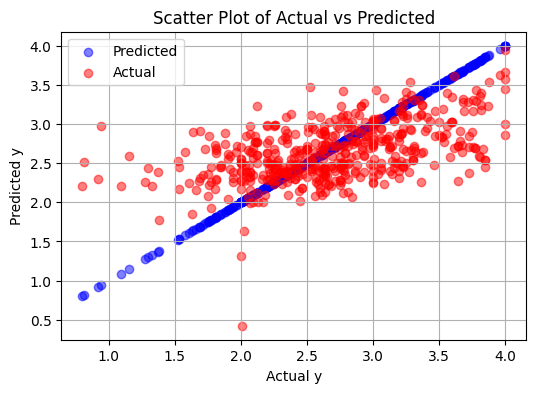

The r2 score is:  0.3230237692455552


In [ ]:
X_norm = (X - mean_X_train)/std_X_train
X_poly = best_poly.fit_transform(X_norm)
y_pred_all_unnormalized = (best_model.predict(X_poly)*std_y_train)+mean_y_train

print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))

numss = [np.random.randint(1,len(y)) for _ in range(500)]
y_rand = y.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y_rand, y_rand, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_rand, y_pred_rand, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()
print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))


REMOVING OUTLIERS

In [ ]:
change = 25

first_quartile = np.percentile(y, change)
fourth_quartile = np.percentile(y, 100-change)

iqr = fourth_quartile - first_quartile

lower_bound = first_quartile - 1.5 * iqr
upper_bound = fourth_quartile + 1.5 * iqr

outlier_indices = np.where((y < lower_bound) | (y > upper_bound))[0]

merged_df_no_OUT = merged_df[(merged_df['gpa'] > lower_bound) & (merged_df['gpa'] < upper_bound)]


X_no_outliers = merged_df_no_OUT[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y_no_outliers = merged_df_no_OUT['gpa']


In [ ]:
best_mse = 10
best_model = 0


kf = KFold(n_splits=3, random_state=None)
total_test_mse = 0
total_train_mse = 0
    
for j, (train_index, test_index) in enumerate(kf.split(X_no_outliers)):

    # Train Test split
    X_train, X_test = X_no_outliers.iloc[train_index], X_no_outliers.iloc[test_index]
    y_train, y_test = y_no_outliers.iloc[train_index], y_no_outliers.iloc[test_index]


    # Normalization
    mean_X_train = np.mean(X_train, axis=0)
    std_X_train = np.std(X_train, axis=0)
    mean_y_train = np.mean(y_train)
    std_y_train = np.std(y_train)


    X_train_norm = (X_train - mean_X_train)/std_X_train
    X_test_norm = (X_test - mean_X_train)/std_X_train

    y_train_norm = (y_train - mean_y_train)/std_y_train
    y_test_norm = (y_test - mean_y_train)/std_y_train

    # Linear Regression
    model = LinearRegression()
    model.fit(X_train_norm, y_train_norm)

    # Train and test MSE
    y_train_predict_unnormalized = (model.predict(X_train_norm) * std_y_train) + mean_y_train
    y_test_predict_unnormalized = (model.predict(X_test_norm) * std_y_train) + mean_y_train

    train_mse = np.mean((y_train_predict_unnormalized - y_train) ** 2)
    test_mse = np.mean((y_test_predict_unnormalized - y_test) ** 2)
    total_train_mse += train_mse
    total_test_mse += test_mse

    if (test_mse < best_mse):
        best_mse = test_mse
        best_model = model

print("Average Train MSE:", total_train_mse / kf.get_n_splits())
print("Average Test MSE:", total_test_mse / kf.get_n_splits())


Average Train MSE: 0.27882171398083905
Average Test MSE: 0.2845323214598053


In [ ]:
X_all_norm = (X_no_outliers - mean_X_train)/std_X_train
y_pred_all = best_model.predict(X_all_norm)
y_pred_all_unnormalized = (y_pred_all * std_y_train) + mean_y_train

print ("The r2 score is: ", r2_score(y_no_outliers,y_pred_all_unnormalized))

The r2 score is:  0.2979862177884639


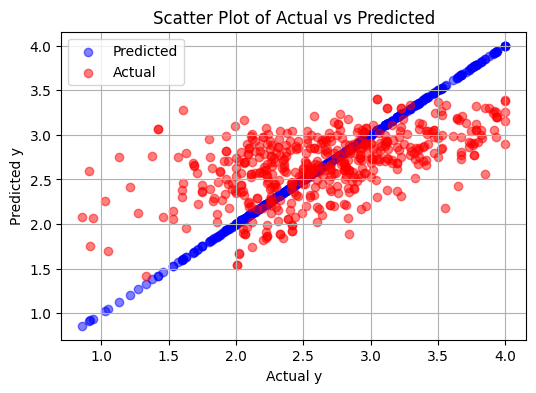

In [ ]:
numss = [np.random.randint(1,len(y_no_outliers)) for _ in range(500)]
y_rand = y_no_outliers.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y_rand, y_rand, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_rand, y_pred_rand, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=50)
best_model = 0
best_mse = 10

# Normalization
mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)


X_train_norm = (X_train - mean_X_train)/std_X_train
X_test_norm = (X_test - mean_X_train)/std_X_train


y_train_norm = (y_train - mean_y_train)/std_y_train
y_test_norm = (y_test - mean_y_train)/std_y_train

degrees = [1,2,4,8]
alphas = [0.1,0.5,1,5,10]
for deg in degrees:

    # Polynomial Features
    poly = PolynomialFeatures(degree=deg, include_bias= True)  # You can adjust the degree as needed
    X_poly_train_norm = poly.fit_transform(X_train_norm)

    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train_norm, y_train_norm)

        X_poly_test_norm = poly.fit_transform(X_test_norm)


        train_mse = mean_squared_error(y_train, (model.predict(X_poly_train_norm)*std_y_train)+mean_y_train)
        test_mse = mean_squared_error(y_test, (model.predict(X_poly_test_norm)*std_y_train)+mean_y_train)
        
        if (test_mse < best_mse):
            best_mse = test_mse
            best_model = model
            best_poly = poly

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=3.36816e-18): result may not be accurate.

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=1.67951e-17): result may not be accurate.

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=3.35387e-17): result may not be accurate.



In [ ]:
X_norm = (X_no_outliers - mean_X_train)/std_X_train
X_poly = best_poly.fit_transform(X_norm)
y_pred_all_unnormalized = (best_model.predict(X_poly)*std_y_train)+mean_y_train

print ("The r2 score is: ", r2_score(y_no_outliers,y_pred_all_unnormalized))


The r2 score is:  0.32130075720068174


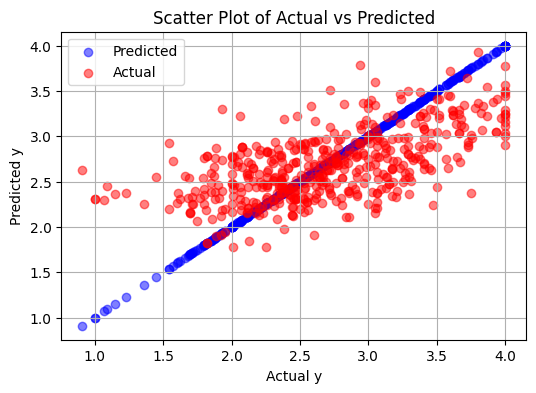

In [ ]:
numss = [np.random.randint(1,len(y_no_outliers)) for _ in range(500)]
y_rand = y_no_outliers.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y_rand, y_rand, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_rand, y_pred_rand, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

The start of <strong>Classification</strong> code cleaning.

In [ ]:
X = merged_df[['SAT', 'athlete','hsize','hsrank','female']] #Same concept here, dropping feature hs percentile as it is dependent on rank and size
y = merged_df['Success']

# Train-test split
def KNNClassification(k):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    model = KNeighborsClassifier(n_neighbors= k)

    #Normalization
    mean_X_train = np.mean(X_train, axis=0)
    std_X_train = np.std(X_train, axis=0)


    X_train_norm = (X_train-mean_X_train)/std_X_train


    model.fit(X_train_norm,y_train)

    X_test_norm = (X_test - mean_X_train)/ std_X_train


    y_pred = model.predict(X_test_norm)

    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Fail", "Success"],)
    cm_display.plot(cmap = "YlOrRd")
    plt.show()

    print(model.score(X_test_norm, y_test))

In [ ]:
def LogisticRegressionClassification(alphaValue):
    model = LogisticRegression(random_state=0, C=alphaValue,fit_intercept=True)
    model.fit(X_train_norm, y_train)

    y_pred = model.predict(X_test_norm)
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Fail", "Success"],)
    cm_display.plot(cmap = "BuPu")
    plt.show()

    print(model.score(X_test_norm, y_test))

In [ ]:
def supportVectorClassifier():
    model = SVC(kernel='rbf', probability=True)
    model.fit(X_train_norm, y_train)

    y_pred = model.predict(X_test_norm)
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Fail", "Success"],)
    cm_display.plot(cmap = "binary")
    plt.show()

    print(model.score(X_test_norm, y_test))


1. Coorelation testing - Heatmaps, pair plots, hypothesis testing,  qq plot 
2. EDA
3. EDA models 
4. Report 

5 (Extra). Understand models extensively



REPORT Ta2SEEMA:
Abstract:
Introduction --> Literature Review:
Methodology --> Code Explanation - Materials and methods:
Results ---> Compare with the github repo:
Conclusion:
References
